<a href="https://colab.research.google.com/github/auroramugnai/ArXivClassification/blob/main/ArXivClassification/category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [ ]:
!git clone https://github.com/auroramugnai/ArXivClassification.git
%cd ArXivClassification/ArXivClassification

Cloning into 'ArXivClassification'...
remote: Enumerating objects: 1766, done.
remote: Counting objects: 100% (408/408), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 1766 (delta 315), reused 271 (delta 230), pack-reused 1358
Receiving objects: 100% (1766/1766), 26.74 MiB | 11.22 MiB/s, done.
Resolving deltas: 100% (930/930), done.
/content/ArXivClassification/ArXivClassification


# 1) Build the dataset

In [ ]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

import utils

In [ ]:
SEED = 42 # fix random seed for reproducibility
random.seed(SEED)

## 1.1 Download the dataset


The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [ ]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
 99% 1.27G/1.28G [00:15<00:00, 82.7MB/s]
100% 1.28G/1.28G [00:15<00:00, 87.6MB/s]


Unzip the downloaded file.

In [ ]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [ ]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## 1.2 Get rid of some unnecessary infomation

In [ ]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).map(cut_info).compute())


# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"[math.AC, math.GM, math.NT, math.RA]",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...


Visualize the dataset distribution.

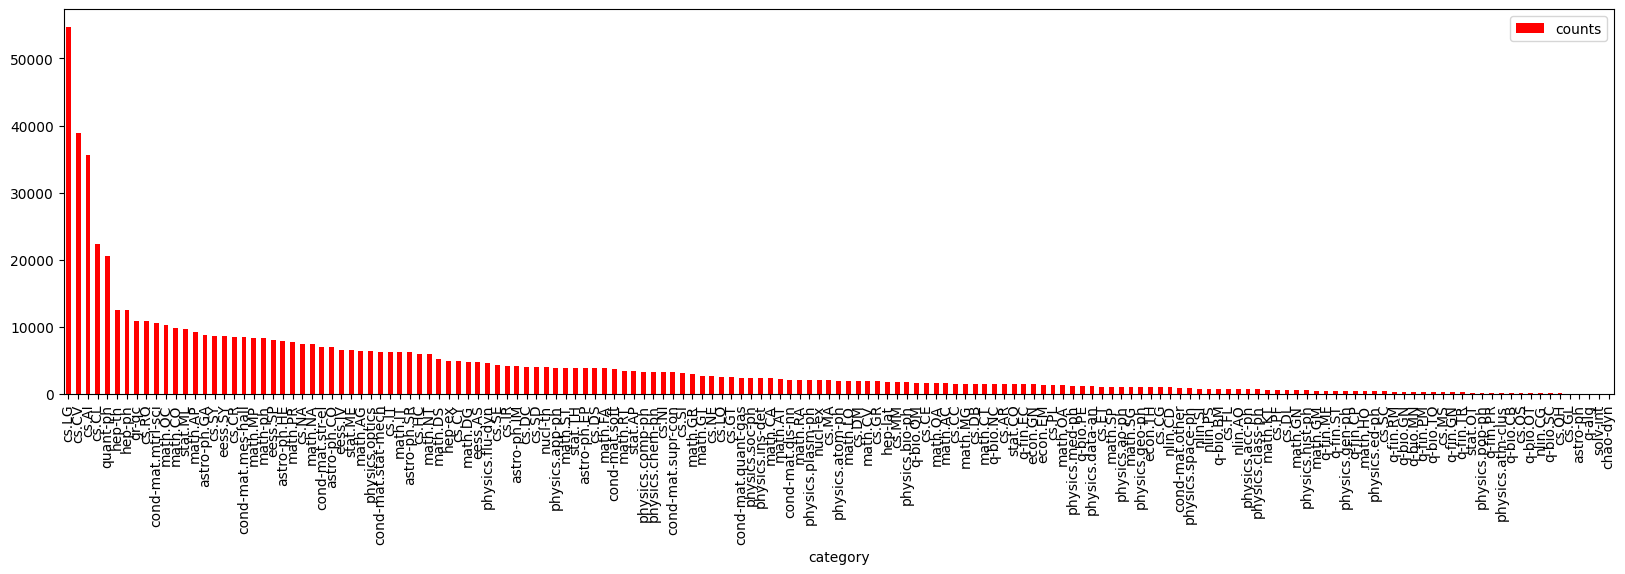

In [ ]:
# Get single-category occurrences.
utils.categories_as_lists(df) # take "category" as a column of lists
df_exp = df.explode("category")
dict_counts_exp = utils.plot_df_counts(df_exp, col="category")

## 1.3 Keep 20 categories

In [ ]:
path = "./arxiv_data_filtered.csv"
df = pd.read_csv(path, dtype=str)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"['math.NA', 'cs.NA']",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,['physics.gen-ph'],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"['math.AC', 'math.GM', 'math.NT', 'math.RA']",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","['math.AG', 'math.NT']","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,['math.NT'],We show a generalization of Mason's ABC-theo...


In [ ]:
# Get the list of all the single categories.
C  = list(dict_counts_exp.keys())
print(f'Number of categories appearing in the dataset: {len(C)}')

num_to_keep = 20 # Keep only a subset of C.
sub_C = random.sample(C, num_to_keep)
print(f'Number of categories appearing in the dataset: {len(sub_C)}')

# Take only the articles with a list of categories whose elements are in sub_C.
utils.categories_as_lists(df) # take "category" as a column of lists
check = lambda x: set(x).issubset(sub_C)
df = df.loc[df["category"].apply(check).loc[lambda x: x].index]
df = df.reset_index(drop=True)
df.head()

Number of categories appearing in the dataset: 159
Number of categories appearing in the dataset: 20


,id,title,category,abstract
0,0801.2057,n-Groupoids and Stacky Groupoids,"[math.DG, math.CT]",We discuss two generalizations of Lie groupo...
1,1006.0048,Approximation of subcategories by abelian subc...,"[math.CT, math.AC]",For a commutative ring $R$ and a weakly pror...
2,1007.2111,Observation of empty liquids and equilibrium g...,[cond-mat.soft],The relevance of anisotropic interactions in...
3,1109.1964,On the harmonicity of normal almost contact me...,[math.DG],We consider normal almost contact structures...
4,1205.0323,Collapsing 4-manifolds under a lower curvature...,[math.DG],In this paper we describe the topology of 4-...


## 1.4 Remove categories with < m samples
First, find categories that have less than m samples, namely "categs_to_drop".
Then, keep articles whose lists of categories have no intersection with "categs_to_drop".


In [ ]:
m = 100
categs_to_drop = [categ for categ,count in dict_counts_exp.items() if count<m]

utils.categories_as_lists(df) # take "category" as a column of lists
has_no_intersection = lambda x: not (set(x) & set(categs_to_drop))
df = df.loc[df["category"].apply(has_no_intersection).loc[lambda x: x].index]

df = df.reset_index(drop=True)
print(f'Number of articles in the dataset: {len(df)}')
df.tail()

Number of articles in the dataset: 18241


,id,title,category,abstract
18236,2405.05896,A note on the volume entropy on a harmonic man...,[math.DG],Harmonic manifolds of hypergeometric type fo...
18237,2405.05960,The effects of bar strength and kinematics on ...,[astro-ph.GA],We study how bar strength and bar kinematics...
18238,cond-mat/0403559,Quantum Dark Soliton: Non-Perturbative Diffusi...,[cond-mat.mes-hall],The dark soliton solution of the Gross-Pitae...
18239,cond-mat/0404352,Scaling dependence on time and distance in non...,[cond-mat.soft],"Recently, fractional derivatives have been e..."
18240,math/0510057,Cryptography and Encryption,[math.CT],"In cryptography, encryption is the process o..."


Visualize the dataset distribution.

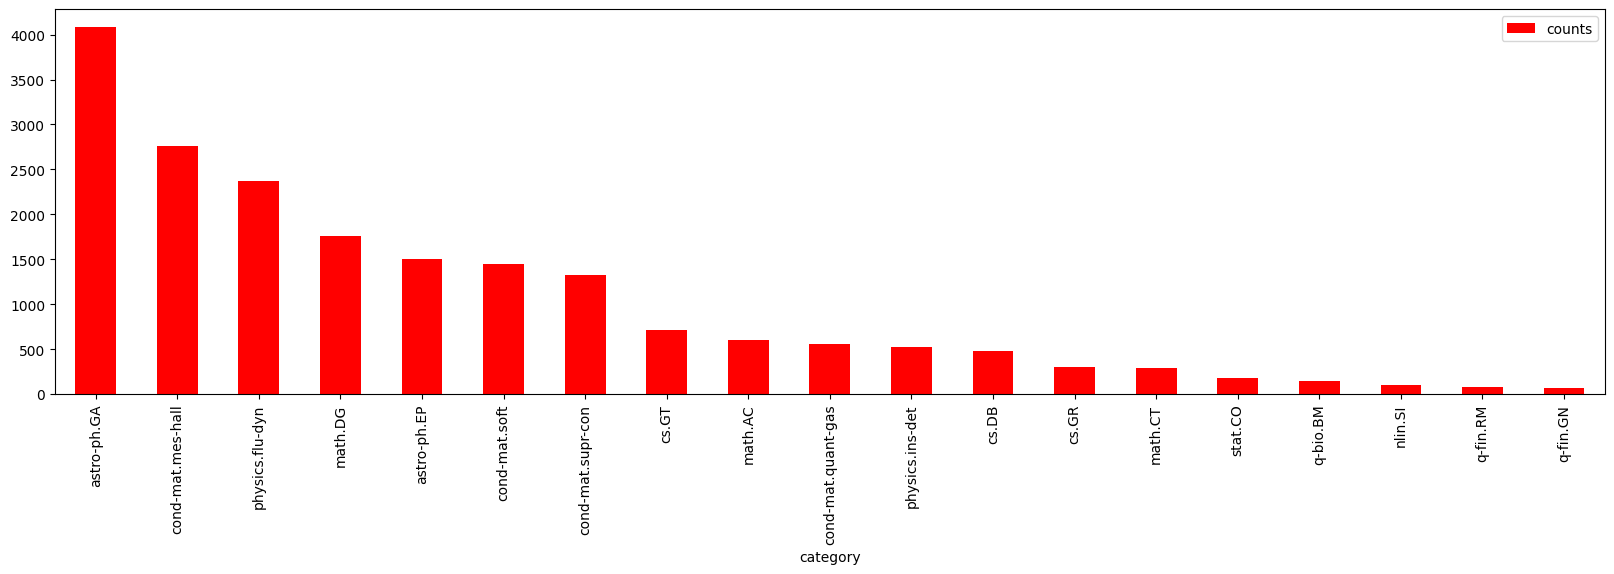

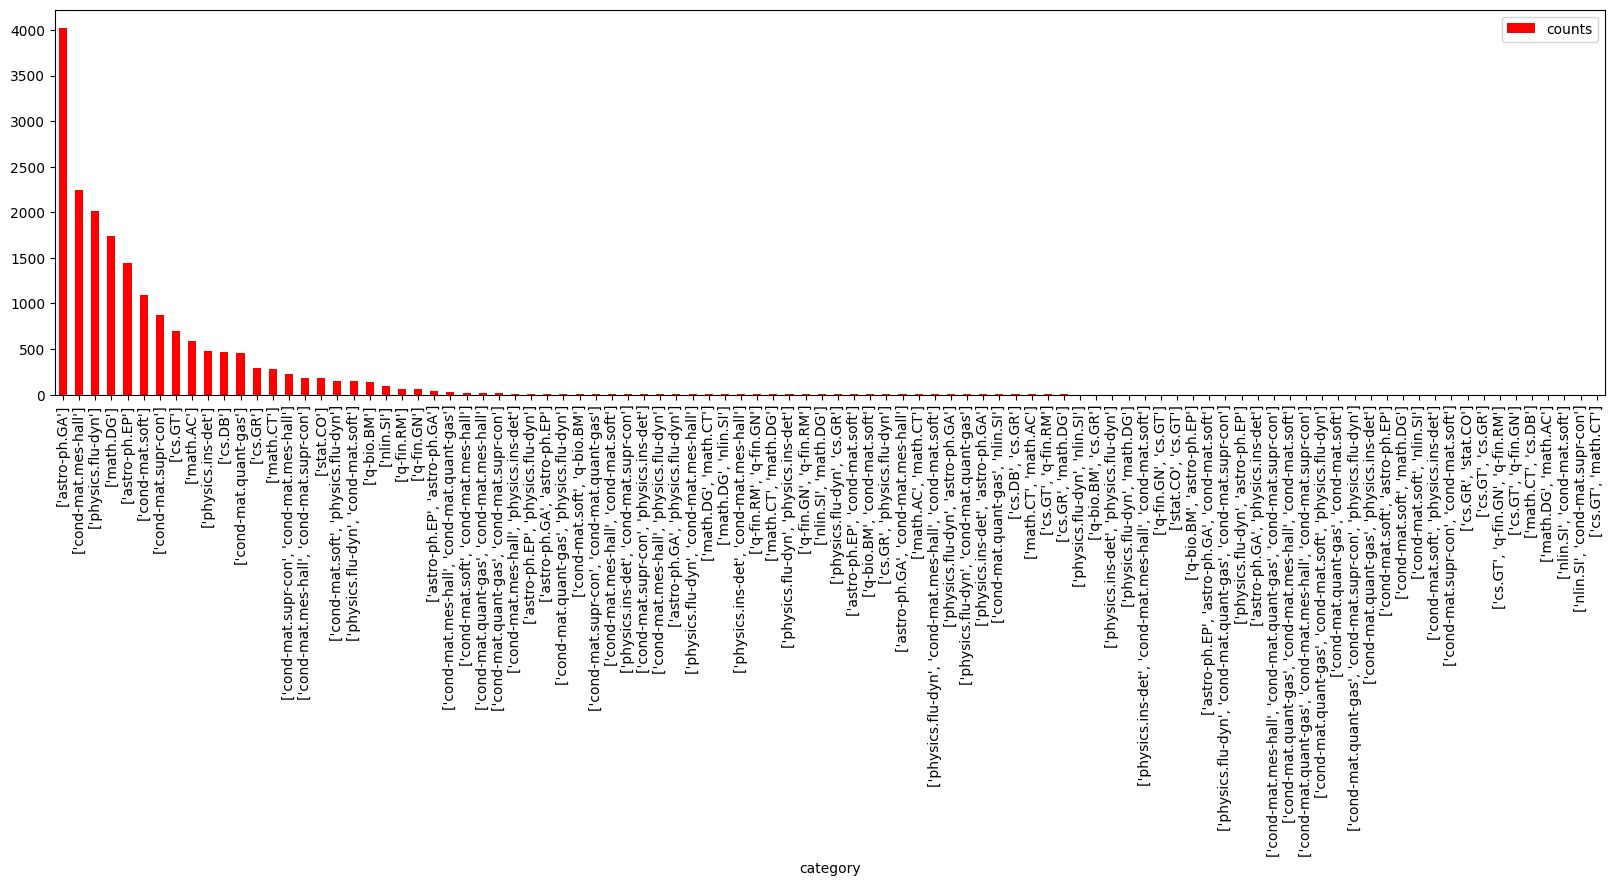

In [ ]:
# Get single-category occurrences.
utils.categories_as_lists(df) # take "category" as a column of lists
df_exp = df.explode("category")
_ = utils.plot_df_counts(df_exp, col="category")

# Get list-of-categories occurrences.
utils.categories_as_strings(df) # take "category" as a column of strings
_ = utils.plot_df_counts(df, col="category")

# 2) Text-processing

In [50]:
!pip install -U spacy -q
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 17.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [51]:
import en_core_web_md
import spacy
from tqdm import tqdm

Clean out the strings (this step will take a while).

In [52]:
# Remove stop words, punctuation, special characters, numbers.
nlp = spacy.load("en_core_web_md")
tqdm.pandas() # to display progress bar

# First on abstracts.
abs_cleaner = lambda x: utils.text_cleaner(text=x["abstract"], nlp=nlp)
df["clean_abstract"] = df.progress_apply(abs_cleaner, axis=1)

# Then on titles.
tit_cleaner = lambda x: utils.text_cleaner(text=x["title"], nlp=nlp)
df["clean_title"] = df.progress_apply(tit_cleaner, axis=1)

df.tail()

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
100%|██████████| 18241/18241 [02:22<00:00, 128.03it/s]


,id,title,category,abstract,clean_abstract,clean_title
18236,2405.05896,A note on the volume entropy on a harmonic man...,['math.DG'],Harmonic manifolds of hypergeometric type fo...,harmonic manifold hypergeometric type form cla...,note volume entropy harmonic manifold hypergeo...
18237,2405.05960,The effects of bar strength and kinematics on ...,['astro-ph.GA'],We study how bar strength and bar kinematics...,study bar strength bar kinematic affect star f...,effect bar strength kinematic galaxy evolution...
18238,cond-mat/0403559,Quantum Dark Soliton: Non-Perturbative Diffusi...,['cond-mat.mes-hall'],The dark soliton solution of the Gross-Pitae...,dark soliton solution gross pitaevskii equatio...,quantum dark soliton non perturbative diffusio...
18239,cond-mat/0404352,Scaling dependence on time and distance in non...,['cond-mat.soft'],"Recently, fractional derivatives have been e...",recently fractional derivative employ analyze ...,scale dependence time distance nonlinear fract...
18240,math/0510057,Cryptography and Encryption,['math.CT'],"In cryptography, encryption is the process o...",cryptography encryption process obscure inform...,cryptography encryption


In [53]:
# Add a space to separate title and abstract.
df["clean_text"] = df["clean_title"] + " " + df["clean_abstract"]

# 3) Multilabel Classification
Given an article:
- its feature X will be the cleaned text
- its label y will be its lists of categories (in a one-hot-encoding)

In [54]:
!pip install scikit-multilearn
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.9 MB/s eta 0:00:00


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.svm import SVC, LinearSVC

from yellowbrick.classifier import ClassificationReport

Prepare features and labels.

In [56]:
# Preparing X (features).
X = df["clean_text"]

# Preparing y (labels) in a one-hot encoding.
utils.categories_as_lists(df) # take "category" as a column of lists
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["category"]) # y is now one-hot encoded
classes = mlb.classes_ # names of the columns of the one-hot-encoding

# Visualize y
y_df = pd.DataFrame(y, columns=classes)
y_df

,astro-ph.EP,astro-ph.GA,cond-mat.mes-hall,cond-mat.quant-gas,cond-mat.soft,cond-mat.supr-con,cs.DB,cs.GR,cs.GT,math.AC,math.CT,math.DG,nlin.SI,physics.flu-dyn,physics.ins-det,q-bio.BM,q-fin.GN,q-fin.RM,stat.CO
0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18236,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
18237,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18238,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18239,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Split data into train/test.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

Do the classification.

accuracy = 0.8576649004202448

                    precision    recall  f1-score   support

       astro-ph.EP       0.99      0.96      0.97       482
       astro-ph.GA       0.99      0.98      0.99      1233
 cond-mat.mes-hall       0.90      0.89      0.89       848
cond-mat.quant-gas       0.95      0.78      0.86       175
     cond-mat.soft       0.86      0.80      0.83       429
 cond-mat.supr-con       0.90      0.85      0.88       416
             cs.DB       1.00      0.89      0.94       129
             cs.GR       0.95      0.61      0.74        88
             cs.GT       0.97      0.94      0.96       224
           math.AC       0.97      0.89      0.93       172
           math.CT       0.97      0.84      0.90        76
           math.DG       1.00      0.98      0.99       497
           nlin.SI       0.94      0.60      0.73        25
   physics.flu-dyn       0.94      0.90      0.92       687
   physics.ins-det       0.98      0.74      0.84       166
        

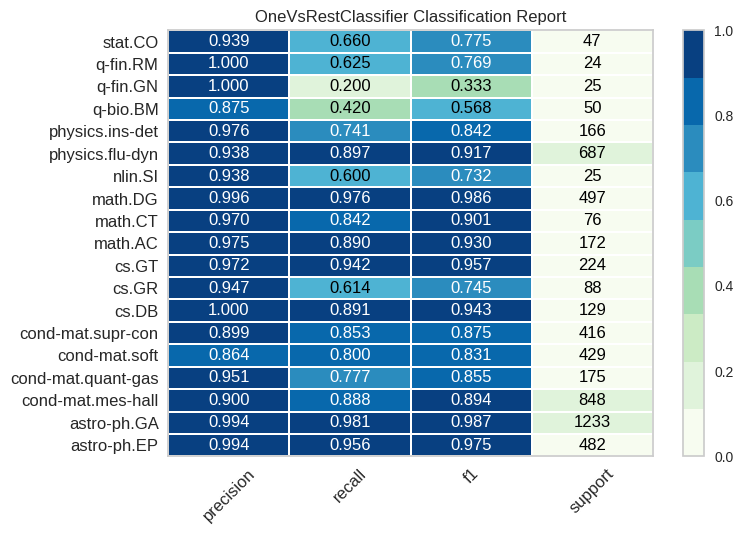

<Axes: title={'center': 'OneVsRestClassifier Classification Report'}>

In [58]:
model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                  ('svm_model', OneVsRestClassifier(LinearSVC(), n_jobs=-1))])

y_pred, mat = utils.run_model(model, X_train, X_test, y_train, y_test,
                              multilabel=True)

print(f'accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred,
                            target_names=classes, zero_division=0.0))

# Show results
visualizer = ClassificationReport(model, classes=classes, support=True, cmap='GnBu')
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

Plot confusion matrices.

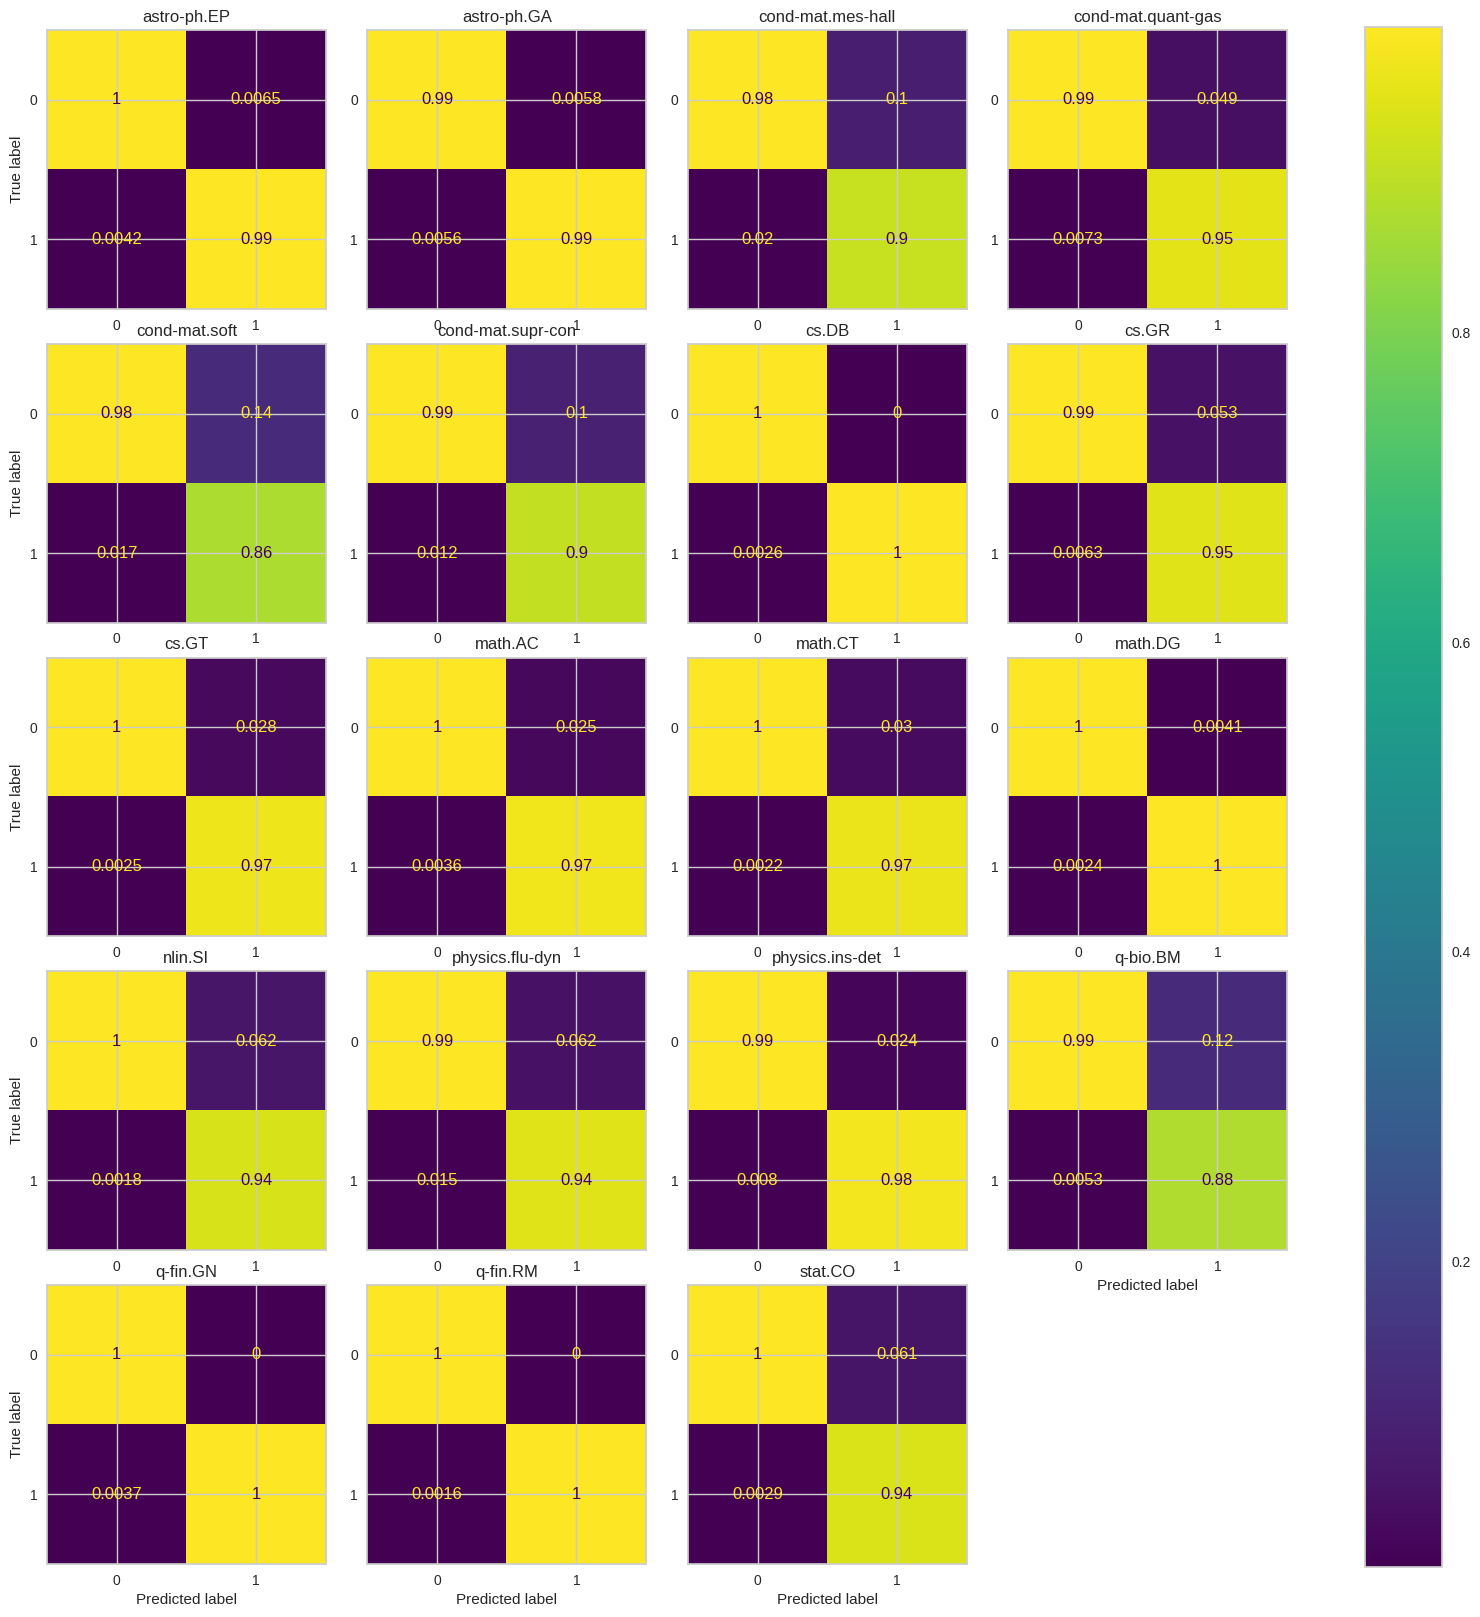

In [59]:
utils.plot_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [60]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

--------------------
  true   : ('physics.flu-dyn',)
predicted: ('physics.flu-dyn',)
--------------------
  true   : ('math.DG',)
predicted: ('math.DG',)
--------------------
  true   : ('astro-ph.GA',)
predicted: ('astro-ph.GA',)
--------------------
  true   : ('astro-ph.GA',)
predicted: ('astro-ph.GA',)
--------------------
  true   : ('cond-mat.soft', 'q-bio.BM')
predicted: ('cond-mat.soft',)
--------------------
  true   : ('math.DG',)
predicted: ('math.DG',)
--------------------
  true   : ('math.DG',)
predicted: ('math.DG',)
--------------------
  true   : ('cs.GT',)
predicted: ('cs.GT',)
--------------------
  true   : ('cond-mat.mes-hall',)
predicted: ('cond-mat.mes-hall',)
--------------------
  true   : ('physics.flu-dyn',)
predicted: ('physics.flu-dyn',)


## ROC curve and Precision-Recall curve

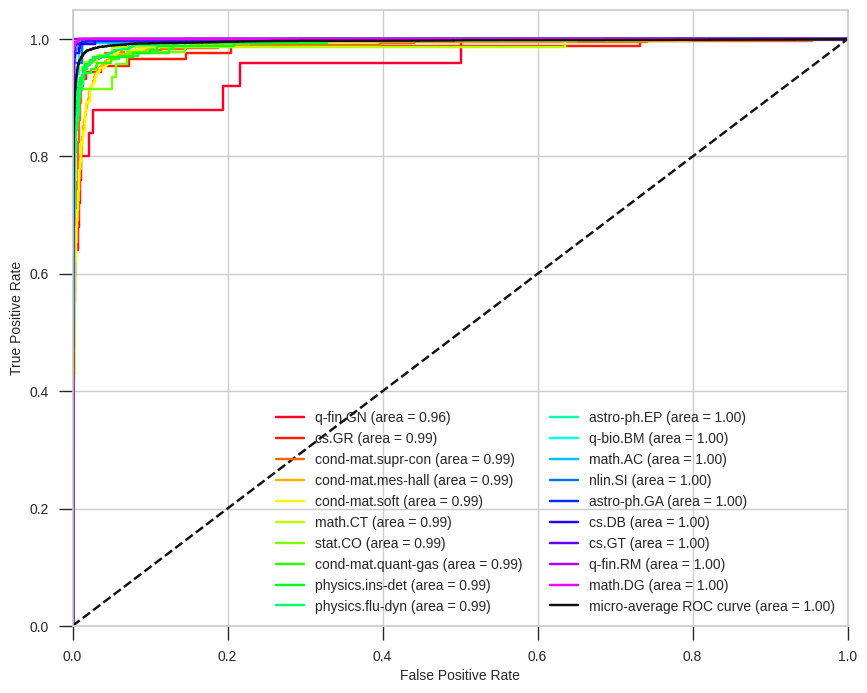

In [61]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)

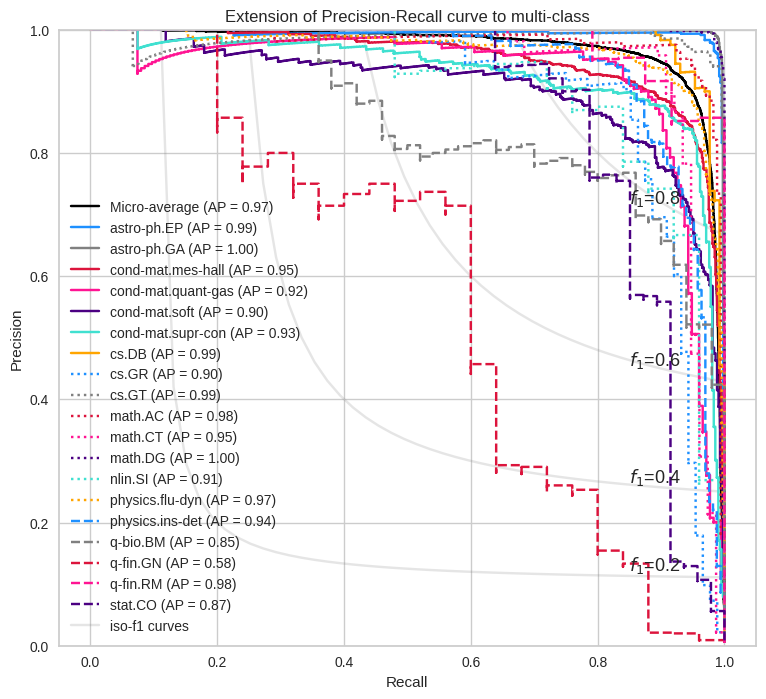

In [65]:
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay
from itertools import cycle
import numpy as np


# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i],
                                                   y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
                                                                y_score.ravel())
average_precision["micro"] = average_precision_score(y_test,
                                                     y_score,
                                                     average="micro")


colors = ["dodgerblue", "gray", "crimson", "deeppink",
          "indigo", "turquoise", "orange"]
num_colors = len(colors)
colorcyler = cycle(colors)

lines = ['-', ':', '--', '-.']
linecycler = cycle(lines)

_, ax = plt.subplots(figsize=(9, 8))
f_scores = np.linspace(0.2, 0.8, num=4)

lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("$f_1$={0:0.1f}".format(f_score),
                 xy=(0.85, y[45]+0.01),
                 fontsize=13)

display = PrecisionRecallDisplay(recall=recall["micro"],
                                 precision=precision["micro"],
                                 average_precision=average_precision["micro"])

display.plot(ax=ax, name="Micro-average", color="black")

linestyle = 'solid'
for i in range(len(classes)):
    display = PrecisionRecallDisplay(recall=recall[i],
                                     precision=precision[i],
                                     average_precision=average_precision[i])

    if not i % num_colors:
        linestyle = next(linecycler)

    color = next(colorcyler)
    display.plot(ax=ax, color=color, name=f"{classes[i]}", linestyle=linestyle)


# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])

# set the legend and the axes
ax.legend(handles=handles, labels=labels, loc="lower left")
ax.set_ylim(0,1)
plt.show()

# 4) Keywords extraction

In [66]:
!pip install KeyBERT -q
!pip install keyphrase-vectorizers -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.5/363.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.8/772.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 60.8 MB/s eta 0:00:00


In [67]:
from keybert import KeyBERT
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
kw_model = KeyBERT('all-mpnet-base-v2')

extraction = lambda x: utils.extract_kws(text=x["clean_text"],
                                         kw_model=kw_model,
                                         seed=x["clean_title"].split(" "))

df["keywords"] = df.progress_apply(extraction, axis=1)

df.to_csv(f"./keywords.csv", index=False) # Save to csv
df.head()

  0%|          | 0/18241 [00:00<?, ?it/s]

# 5) Multilabel Classification #2
Repeat the classification.
This time, given an article:
- its feature X will be the list of its keywords
- its label y will be its lists of categories (in a one-hot-encoding)


In [ ]:
# Preparing X (features).
X = df["keywords"].map(lambda x: " ".join(x))


# Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

In [ ]:
y_pred, mat = utils.run_model(model, X_train, X_test, y_train, y_test,
                              multilabel=True)

print(f'accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred,
                            target_names=classes, zero_division=0.0))

Plot confusion matrices.

In [ ]:
utils.plot_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [ ]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

Plot the ROC curve.

In [ ]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)